# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

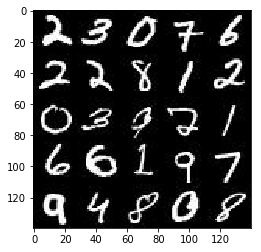

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

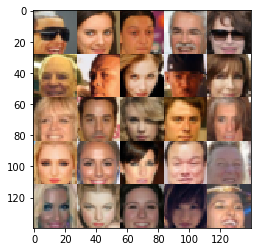

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z    = tf.placeholder(tf.float32, (None, z_dim),name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope( 'discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images = data_shape[0]
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    ### Build GAN
    
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = n_images // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            nbSteps = 0
            for batch_images in get_batches(batch_size):
                nbSteps += 1

                # Scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                # run discriminator optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate}) 
                # run generator optimizer
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out                
                if nbSteps % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} , Batch {}/{}: ".format(epoch_i+1, epoch_count, nbSteps, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if nbSteps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 , Batch 10/1875:  Discriminator loss = 0.6969  Generator loss = 9.5488
Epoch 1/2 , Batch 20/1875:  Discriminator loss = 2.9969  Generator loss = 10.8300
Epoch 1/2 , Batch 30/1875:  Discriminator loss = 2.2273  Generator loss = 11.0765
Epoch 1/2 , Batch 40/1875:  Discriminator loss = 0.6439  Generator loss = 2.5999
Epoch 1/2 , Batch 50/1875:  Discriminator loss = 2.9662  Generator loss = 0.1843
Epoch 1/2 , Batch 60/1875:  Discriminator loss = 1.8691  Generator loss = 0.6017
Epoch 1/2 , Batch 70/1875:  Discriminator loss = 2.3962  Generator loss = 3.5931
Epoch 1/2 , Batch 80/1875:  Discriminator loss = 1.3759  Generator loss = 3.9895
Epoch 1/2 , Batch 90/1875:  Discriminator loss = 2.2891  Generator loss = 4.1657
Epoch 1/2 , Batch 100/1875:  Discriminator loss = 1.0149  Generator loss = 2.5679


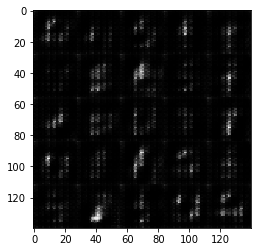

Epoch 1/2 , Batch 110/1875:  Discriminator loss = 1.0501  Generator loss = 1.1543
Epoch 1/2 , Batch 120/1875:  Discriminator loss = 0.9937  Generator loss = 1.4242
Epoch 1/2 , Batch 130/1875:  Discriminator loss = 1.2648  Generator loss = 0.7349
Epoch 1/2 , Batch 140/1875:  Discriminator loss = 1.5119  Generator loss = 3.1196
Epoch 1/2 , Batch 150/1875:  Discriminator loss = 1.3064  Generator loss = 1.0227
Epoch 1/2 , Batch 160/1875:  Discriminator loss = 1.7587  Generator loss = 0.3863
Epoch 1/2 , Batch 170/1875:  Discriminator loss = 1.5440  Generator loss = 1.2082
Epoch 1/2 , Batch 180/1875:  Discriminator loss = 1.5004  Generator loss = 1.0571
Epoch 1/2 , Batch 190/1875:  Discriminator loss = 2.1303  Generator loss = 2.1605
Epoch 1/2 , Batch 200/1875:  Discriminator loss = 1.8213  Generator loss = 0.3740


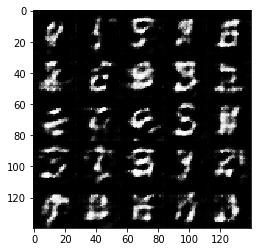

Epoch 1/2 , Batch 210/1875:  Discriminator loss = 1.0369  Generator loss = 0.9579
Epoch 1/2 , Batch 220/1875:  Discriminator loss = 1.6412  Generator loss = 0.6856
Epoch 1/2 , Batch 230/1875:  Discriminator loss = 1.5897  Generator loss = 1.7077
Epoch 1/2 , Batch 240/1875:  Discriminator loss = 1.1474  Generator loss = 1.0221
Epoch 1/2 , Batch 250/1875:  Discriminator loss = 1.3049  Generator loss = 0.7055
Epoch 1/2 , Batch 260/1875:  Discriminator loss = 1.2522  Generator loss = 0.9566
Epoch 1/2 , Batch 270/1875:  Discriminator loss = 1.7855  Generator loss = 0.3331
Epoch 1/2 , Batch 280/1875:  Discriminator loss = 1.5878  Generator loss = 0.4720
Epoch 1/2 , Batch 290/1875:  Discriminator loss = 1.3879  Generator loss = 0.7600
Epoch 1/2 , Batch 300/1875:  Discriminator loss = 1.3392  Generator loss = 0.8874


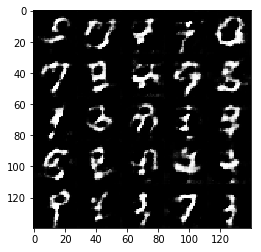

Epoch 1/2 , Batch 310/1875:  Discriminator loss = 1.5493  Generator loss = 0.4314
Epoch 1/2 , Batch 320/1875:  Discriminator loss = 1.8788  Generator loss = 0.3707
Epoch 1/2 , Batch 330/1875:  Discriminator loss = 1.5570  Generator loss = 0.4958
Epoch 1/2 , Batch 340/1875:  Discriminator loss = 1.2658  Generator loss = 0.9464
Epoch 1/2 , Batch 350/1875:  Discriminator loss = 1.4464  Generator loss = 1.0479
Epoch 1/2 , Batch 360/1875:  Discriminator loss = 1.7002  Generator loss = 0.9331
Epoch 1/2 , Batch 370/1875:  Discriminator loss = 1.6380  Generator loss = 0.4259
Epoch 1/2 , Batch 380/1875:  Discriminator loss = 1.2910  Generator loss = 1.8386
Epoch 1/2 , Batch 390/1875:  Discriminator loss = 1.1547  Generator loss = 1.0941
Epoch 1/2 , Batch 400/1875:  Discriminator loss = 1.2901  Generator loss = 0.9931


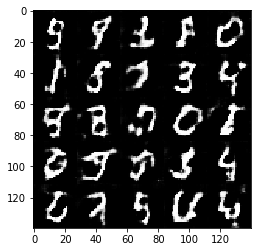

Epoch 1/2 , Batch 410/1875:  Discriminator loss = 1.2723  Generator loss = 0.7278
Epoch 1/2 , Batch 420/1875:  Discriminator loss = 1.3599  Generator loss = 0.6483
Epoch 1/2 , Batch 430/1875:  Discriminator loss = 1.1117  Generator loss = 0.8610
Epoch 1/2 , Batch 440/1875:  Discriminator loss = 1.4146  Generator loss = 1.2763
Epoch 1/2 , Batch 450/1875:  Discriminator loss = 1.7647  Generator loss = 0.3755
Epoch 1/2 , Batch 460/1875:  Discriminator loss = 1.8651  Generator loss = 0.3279
Epoch 1/2 , Batch 470/1875:  Discriminator loss = 1.4220  Generator loss = 0.6717
Epoch 1/2 , Batch 480/1875:  Discriminator loss = 1.3182  Generator loss = 0.6295
Epoch 1/2 , Batch 490/1875:  Discriminator loss = 1.3186  Generator loss = 0.5931
Epoch 1/2 , Batch 500/1875:  Discriminator loss = 1.3420  Generator loss = 0.8371


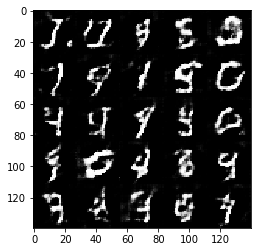

Epoch 1/2 , Batch 510/1875:  Discriminator loss = 1.7099  Generator loss = 0.4068
Epoch 1/2 , Batch 520/1875:  Discriminator loss = 1.3314  Generator loss = 0.6804
Epoch 1/2 , Batch 530/1875:  Discriminator loss = 1.6986  Generator loss = 0.4358
Epoch 1/2 , Batch 540/1875:  Discriminator loss = 1.3732  Generator loss = 1.0771
Epoch 1/2 , Batch 550/1875:  Discriminator loss = 1.4061  Generator loss = 0.6797
Epoch 1/2 , Batch 560/1875:  Discriminator loss = 1.4326  Generator loss = 0.5797
Epoch 1/2 , Batch 570/1875:  Discriminator loss = 1.3732  Generator loss = 0.6959
Epoch 1/2 , Batch 580/1875:  Discriminator loss = 1.3136  Generator loss = 0.9127
Epoch 1/2 , Batch 590/1875:  Discriminator loss = 1.5025  Generator loss = 1.0456
Epoch 1/2 , Batch 600/1875:  Discriminator loss = 1.1984  Generator loss = 0.7370


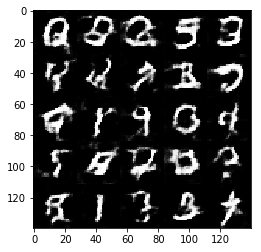

Epoch 1/2 , Batch 610/1875:  Discriminator loss = 1.7184  Generator loss = 0.3873
Epoch 1/2 , Batch 620/1875:  Discriminator loss = 1.5278  Generator loss = 0.9575
Epoch 1/2 , Batch 630/1875:  Discriminator loss = 1.2713  Generator loss = 1.0722
Epoch 1/2 , Batch 640/1875:  Discriminator loss = 1.1795  Generator loss = 0.7857
Epoch 1/2 , Batch 650/1875:  Discriminator loss = 1.4065  Generator loss = 1.0290
Epoch 1/2 , Batch 660/1875:  Discriminator loss = 1.4036  Generator loss = 0.8619
Epoch 1/2 , Batch 670/1875:  Discriminator loss = 1.3705  Generator loss = 0.8485
Epoch 1/2 , Batch 680/1875:  Discriminator loss = 1.2010  Generator loss = 0.8289
Epoch 1/2 , Batch 690/1875:  Discriminator loss = 1.4602  Generator loss = 0.7898
Epoch 1/2 , Batch 700/1875:  Discriminator loss = 1.2750  Generator loss = 1.0715


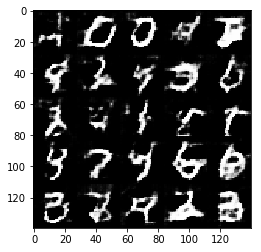

Epoch 1/2 , Batch 710/1875:  Discriminator loss = 1.5522  Generator loss = 0.4395
Epoch 1/2 , Batch 720/1875:  Discriminator loss = 1.4960  Generator loss = 0.5035
Epoch 1/2 , Batch 730/1875:  Discriminator loss = 1.5864  Generator loss = 1.5463
Epoch 1/2 , Batch 740/1875:  Discriminator loss = 1.7872  Generator loss = 0.3769
Epoch 1/2 , Batch 750/1875:  Discriminator loss = 1.2022  Generator loss = 1.1784
Epoch 1/2 , Batch 760/1875:  Discriminator loss = 1.3194  Generator loss = 1.2084
Epoch 1/2 , Batch 770/1875:  Discriminator loss = 1.5119  Generator loss = 0.7935
Epoch 1/2 , Batch 780/1875:  Discriminator loss = 1.3220  Generator loss = 0.7279
Epoch 1/2 , Batch 790/1875:  Discriminator loss = 1.3880  Generator loss = 0.6686
Epoch 1/2 , Batch 800/1875:  Discriminator loss = 1.5516  Generator loss = 0.4435


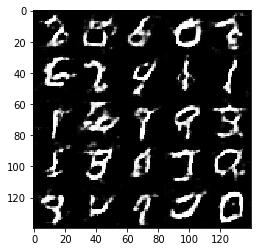

Epoch 1/2 , Batch 810/1875:  Discriminator loss = 1.6529  Generator loss = 0.3852
Epoch 1/2 , Batch 820/1875:  Discriminator loss = 1.3807  Generator loss = 0.6401
Epoch 1/2 , Batch 830/1875:  Discriminator loss = 1.4600  Generator loss = 1.4773
Epoch 1/2 , Batch 840/1875:  Discriminator loss = 1.8502  Generator loss = 0.3082
Epoch 1/2 , Batch 850/1875:  Discriminator loss = 1.8546  Generator loss = 0.3025
Epoch 1/2 , Batch 860/1875:  Discriminator loss = 1.2707  Generator loss = 0.8900
Epoch 1/2 , Batch 870/1875:  Discriminator loss = 1.4337  Generator loss = 1.8082
Epoch 1/2 , Batch 880/1875:  Discriminator loss = 1.3596  Generator loss = 1.0335
Epoch 1/2 , Batch 890/1875:  Discriminator loss = 1.2740  Generator loss = 1.1512
Epoch 1/2 , Batch 900/1875:  Discriminator loss = 1.3192  Generator loss = 0.6657


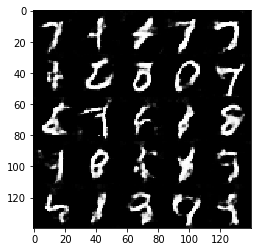

Epoch 1/2 , Batch 910/1875:  Discriminator loss = 1.5203  Generator loss = 1.2402
Epoch 1/2 , Batch 920/1875:  Discriminator loss = 1.4589  Generator loss = 0.4792
Epoch 1/2 , Batch 930/1875:  Discriminator loss = 1.6910  Generator loss = 1.8771
Epoch 1/2 , Batch 940/1875:  Discriminator loss = 1.3430  Generator loss = 0.8473
Epoch 1/2 , Batch 950/1875:  Discriminator loss = 1.4848  Generator loss = 1.6144
Epoch 1/2 , Batch 960/1875:  Discriminator loss = 1.3914  Generator loss = 0.6617
Epoch 1/2 , Batch 970/1875:  Discriminator loss = 1.2760  Generator loss = 0.9061
Epoch 1/2 , Batch 980/1875:  Discriminator loss = 1.3654  Generator loss = 1.4552
Epoch 1/2 , Batch 990/1875:  Discriminator loss = 1.2739  Generator loss = 0.7228
Epoch 1/2 , Batch 1000/1875:  Discriminator loss = 1.4024  Generator loss = 1.0874


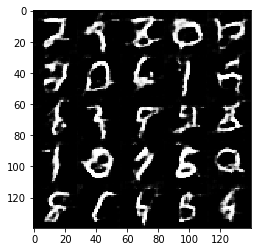

Epoch 1/2 , Batch 1010/1875:  Discriminator loss = 1.6334  Generator loss = 0.3955
Epoch 1/2 , Batch 1020/1875:  Discriminator loss = 1.2753  Generator loss = 0.7154
Epoch 1/2 , Batch 1030/1875:  Discriminator loss = 1.3332  Generator loss = 0.8346
Epoch 1/2 , Batch 1040/1875:  Discriminator loss = 1.7281  Generator loss = 0.3912
Epoch 1/2 , Batch 1050/1875:  Discriminator loss = 1.8346  Generator loss = 0.3388
Epoch 1/2 , Batch 1060/1875:  Discriminator loss = 1.7184  Generator loss = 0.3500
Epoch 1/2 , Batch 1070/1875:  Discriminator loss = 1.5670  Generator loss = 2.0368
Epoch 1/2 , Batch 1080/1875:  Discriminator loss = 1.1833  Generator loss = 0.8013
Epoch 1/2 , Batch 1090/1875:  Discriminator loss = 1.7660  Generator loss = 1.9610
Epoch 1/2 , Batch 1100/1875:  Discriminator loss = 1.6155  Generator loss = 0.4404


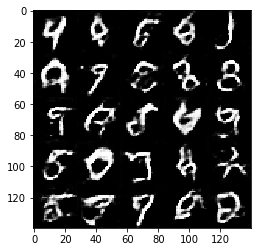

Epoch 1/2 , Batch 1110/1875:  Discriminator loss = 1.3821  Generator loss = 0.8644
Epoch 1/2 , Batch 1120/1875:  Discriminator loss = 1.5124  Generator loss = 0.4951
Epoch 1/2 , Batch 1130/1875:  Discriminator loss = 1.5584  Generator loss = 0.4687
Epoch 1/2 , Batch 1140/1875:  Discriminator loss = 1.6789  Generator loss = 0.9390
Epoch 1/2 , Batch 1150/1875:  Discriminator loss = 2.2379  Generator loss = 0.2600
Epoch 1/2 , Batch 1160/1875:  Discriminator loss = 1.3677  Generator loss = 0.7318
Epoch 1/2 , Batch 1170/1875:  Discriminator loss = 1.5005  Generator loss = 2.0341
Epoch 1/2 , Batch 1180/1875:  Discriminator loss = 1.6491  Generator loss = 1.6185
Epoch 1/2 , Batch 1190/1875:  Discriminator loss = 1.2983  Generator loss = 0.9301
Epoch 1/2 , Batch 1200/1875:  Discriminator loss = 1.1987  Generator loss = 0.7349


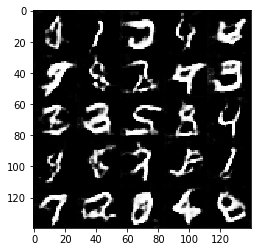

Epoch 1/2 , Batch 1210/1875:  Discriminator loss = 1.6716  Generator loss = 0.3868
Epoch 1/2 , Batch 1220/1875:  Discriminator loss = 1.5875  Generator loss = 0.4666
Epoch 1/2 , Batch 1230/1875:  Discriminator loss = 1.3742  Generator loss = 0.9930
Epoch 1/2 , Batch 1240/1875:  Discriminator loss = 1.3283  Generator loss = 1.0448
Epoch 1/2 , Batch 1250/1875:  Discriminator loss = 1.7229  Generator loss = 0.4572
Epoch 1/2 , Batch 1260/1875:  Discriminator loss = 1.1199  Generator loss = 0.8709
Epoch 1/2 , Batch 1270/1875:  Discriminator loss = 1.5745  Generator loss = 0.3973
Epoch 1/2 , Batch 1280/1875:  Discriminator loss = 1.3365  Generator loss = 0.6753
Epoch 1/2 , Batch 1290/1875:  Discriminator loss = 1.5222  Generator loss = 1.8293
Epoch 1/2 , Batch 1300/1875:  Discriminator loss = 1.6614  Generator loss = 0.3909


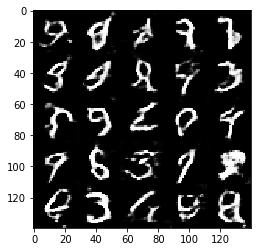

Epoch 1/2 , Batch 1310/1875:  Discriminator loss = 1.2498  Generator loss = 1.0637
Epoch 1/2 , Batch 1320/1875:  Discriminator loss = 1.9217  Generator loss = 0.2963
Epoch 1/2 , Batch 1330/1875:  Discriminator loss = 1.5979  Generator loss = 0.4077
Epoch 1/2 , Batch 1340/1875:  Discriminator loss = 1.4746  Generator loss = 0.4843
Epoch 1/2 , Batch 1350/1875:  Discriminator loss = 1.1513  Generator loss = 0.7294
Epoch 1/2 , Batch 1360/1875:  Discriminator loss = 1.0360  Generator loss = 1.0081
Epoch 1/2 , Batch 1370/1875:  Discriminator loss = 1.2687  Generator loss = 1.7286
Epoch 1/2 , Batch 1380/1875:  Discriminator loss = 1.4096  Generator loss = 0.5880
Epoch 1/2 , Batch 1390/1875:  Discriminator loss = 1.5226  Generator loss = 0.4583
Epoch 1/2 , Batch 1400/1875:  Discriminator loss = 1.1789  Generator loss = 1.0002


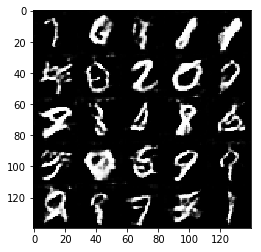

Epoch 1/2 , Batch 1410/1875:  Discriminator loss = 1.2321  Generator loss = 0.8251
Epoch 1/2 , Batch 1420/1875:  Discriminator loss = 1.8323  Generator loss = 0.3005
Epoch 1/2 , Batch 1430/1875:  Discriminator loss = 1.2727  Generator loss = 0.6030
Epoch 1/2 , Batch 1440/1875:  Discriminator loss = 1.3273  Generator loss = 0.6020
Epoch 1/2 , Batch 1450/1875:  Discriminator loss = 1.1098  Generator loss = 1.7246
Epoch 1/2 , Batch 1460/1875:  Discriminator loss = 1.0837  Generator loss = 1.3461
Epoch 1/2 , Batch 1470/1875:  Discriminator loss = 1.0618  Generator loss = 1.1462
Epoch 1/2 , Batch 1480/1875:  Discriminator loss = 1.2511  Generator loss = 0.9911
Epoch 1/2 , Batch 1490/1875:  Discriminator loss = 1.5374  Generator loss = 0.4136
Epoch 1/2 , Batch 1500/1875:  Discriminator loss = 1.2809  Generator loss = 1.3988


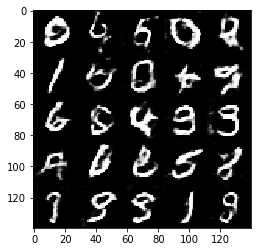

Epoch 1/2 , Batch 1510/1875:  Discriminator loss = 1.3999  Generator loss = 0.5806
Epoch 1/2 , Batch 1520/1875:  Discriminator loss = 1.5390  Generator loss = 0.4227
Epoch 1/2 , Batch 1530/1875:  Discriminator loss = 1.3785  Generator loss = 0.5915
Epoch 1/2 , Batch 1540/1875:  Discriminator loss = 1.7102  Generator loss = 0.3294
Epoch 1/2 , Batch 1550/1875:  Discriminator loss = 0.8858  Generator loss = 1.2602
Epoch 1/2 , Batch 1560/1875:  Discriminator loss = 1.8347  Generator loss = 0.3078
Epoch 1/2 , Batch 1570/1875:  Discriminator loss = 1.1238  Generator loss = 0.7161
Epoch 1/2 , Batch 1580/1875:  Discriminator loss = 1.1385  Generator loss = 0.9978
Epoch 1/2 , Batch 1590/1875:  Discriminator loss = 1.1798  Generator loss = 2.2227
Epoch 1/2 , Batch 1600/1875:  Discriminator loss = 1.1855  Generator loss = 0.7146


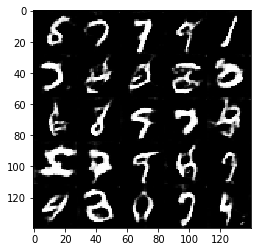

Epoch 1/2 , Batch 1610/1875:  Discriminator loss = 1.3882  Generator loss = 2.0442
Epoch 1/2 , Batch 1620/1875:  Discriminator loss = 1.2757  Generator loss = 0.9466
Epoch 1/2 , Batch 1630/1875:  Discriminator loss = 0.9360  Generator loss = 1.1552
Epoch 1/2 , Batch 1640/1875:  Discriminator loss = 1.4000  Generator loss = 1.8686
Epoch 1/2 , Batch 1650/1875:  Discriminator loss = 1.0870  Generator loss = 1.0129
Epoch 1/2 , Batch 1660/1875:  Discriminator loss = 1.2491  Generator loss = 0.6057
Epoch 1/2 , Batch 1670/1875:  Discriminator loss = 0.8962  Generator loss = 1.1540
Epoch 1/2 , Batch 1680/1875:  Discriminator loss = 1.2018  Generator loss = 0.9889
Epoch 1/2 , Batch 1690/1875:  Discriminator loss = 0.9195  Generator loss = 1.8819
Epoch 1/2 , Batch 1700/1875:  Discriminator loss = 0.9203  Generator loss = 1.6184


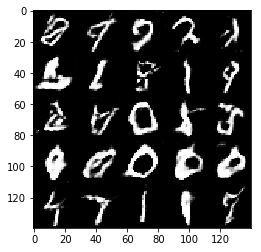

Epoch 1/2 , Batch 1710/1875:  Discriminator loss = 1.4091  Generator loss = 0.5605
Epoch 1/2 , Batch 1720/1875:  Discriminator loss = 1.5181  Generator loss = 0.4384
Epoch 1/2 , Batch 1730/1875:  Discriminator loss = 1.8814  Generator loss = 0.2996
Epoch 1/2 , Batch 1740/1875:  Discriminator loss = 1.3641  Generator loss = 0.5013
Epoch 1/2 , Batch 1750/1875:  Discriminator loss = 1.0369  Generator loss = 1.4915
Epoch 1/2 , Batch 1760/1875:  Discriminator loss = 0.9140  Generator loss = 1.4211
Epoch 1/2 , Batch 1770/1875:  Discriminator loss = 1.0231  Generator loss = 0.7582
Epoch 1/2 , Batch 1780/1875:  Discriminator loss = 1.6940  Generator loss = 0.3483
Epoch 1/2 , Batch 1790/1875:  Discriminator loss = 0.8638  Generator loss = 1.2117
Epoch 1/2 , Batch 1800/1875:  Discriminator loss = 1.0432  Generator loss = 1.6109


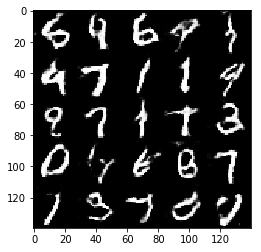

Epoch 1/2 , Batch 1810/1875:  Discriminator loss = 1.8053  Generator loss = 0.4615
Epoch 1/2 , Batch 1820/1875:  Discriminator loss = 1.7029  Generator loss = 0.3975
Epoch 1/2 , Batch 1830/1875:  Discriminator loss = 1.2065  Generator loss = 1.8155
Epoch 1/2 , Batch 1840/1875:  Discriminator loss = 1.2140  Generator loss = 0.8686
Epoch 1/2 , Batch 1850/1875:  Discriminator loss = 1.8687  Generator loss = 0.3345
Epoch 1/2 , Batch 1860/1875:  Discriminator loss = 1.5721  Generator loss = 0.4218
Epoch 1/2 , Batch 1870/1875:  Discriminator loss = 0.9836  Generator loss = 0.8677
Epoch 2/2 , Batch 10/1875:  Discriminator loss = 0.7572  Generator loss = 1.1471
Epoch 2/2 , Batch 20/1875:  Discriminator loss = 2.5497  Generator loss = 0.1562
Epoch 2/2 , Batch 30/1875:  Discriminator loss = 1.6493  Generator loss = 0.3753
Epoch 2/2 , Batch 40/1875:  Discriminator loss = 1.1127  Generator loss = 0.8165
Epoch 2/2 , Batch 50/1875:  Discriminator loss = 1.0905  Generator loss = 0.7361
Epoch 2/2 , Ba

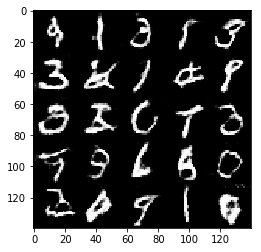

Epoch 2/2 , Batch 110/1875:  Discriminator loss = 1.1515  Generator loss = 0.7433
Epoch 2/2 , Batch 120/1875:  Discriminator loss = 0.9399  Generator loss = 0.9519
Epoch 2/2 , Batch 130/1875:  Discriminator loss = 2.1488  Generator loss = 2.5517
Epoch 2/2 , Batch 140/1875:  Discriminator loss = 0.8439  Generator loss = 1.1160
Epoch 2/2 , Batch 150/1875:  Discriminator loss = 1.2029  Generator loss = 2.1158
Epoch 2/2 , Batch 160/1875:  Discriminator loss = 1.4870  Generator loss = 0.4611
Epoch 2/2 , Batch 170/1875:  Discriminator loss = 0.9005  Generator loss = 1.2625
Epoch 2/2 , Batch 180/1875:  Discriminator loss = 1.4493  Generator loss = 0.4628
Epoch 2/2 , Batch 190/1875:  Discriminator loss = 0.9259  Generator loss = 0.9424
Epoch 2/2 , Batch 200/1875:  Discriminator loss = 1.3881  Generator loss = 0.5192


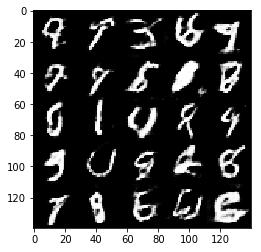

Epoch 2/2 , Batch 210/1875:  Discriminator loss = 0.9740  Generator loss = 0.8209
Epoch 2/2 , Batch 220/1875:  Discriminator loss = 1.3049  Generator loss = 0.8828
Epoch 2/2 , Batch 230/1875:  Discriminator loss = 1.0532  Generator loss = 1.6036
Epoch 2/2 , Batch 240/1875:  Discriminator loss = 1.0425  Generator loss = 0.8012
Epoch 2/2 , Batch 250/1875:  Discriminator loss = 1.7233  Generator loss = 0.3871
Epoch 2/2 , Batch 260/1875:  Discriminator loss = 0.7375  Generator loss = 1.4355
Epoch 2/2 , Batch 270/1875:  Discriminator loss = 2.1352  Generator loss = 0.2300
Epoch 2/2 , Batch 280/1875:  Discriminator loss = 1.2262  Generator loss = 0.6583
Epoch 2/2 , Batch 290/1875:  Discriminator loss = 0.7710  Generator loss = 1.7581
Epoch 2/2 , Batch 300/1875:  Discriminator loss = 2.9941  Generator loss = 0.1189


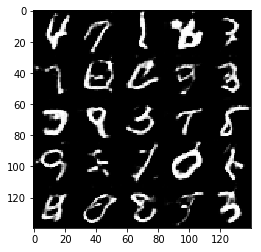

Epoch 2/2 , Batch 310/1875:  Discriminator loss = 0.8373  Generator loss = 1.2506
Epoch 2/2 , Batch 320/1875:  Discriminator loss = 0.7464  Generator loss = 1.3007
Epoch 2/2 , Batch 330/1875:  Discriminator loss = 1.1796  Generator loss = 0.6886
Epoch 2/2 , Batch 340/1875:  Discriminator loss = 1.4332  Generator loss = 0.5011
Epoch 2/2 , Batch 350/1875:  Discriminator loss = 0.8761  Generator loss = 0.9994
Epoch 2/2 , Batch 360/1875:  Discriminator loss = 1.9656  Generator loss = 4.4753
Epoch 2/2 , Batch 370/1875:  Discriminator loss = 1.0331  Generator loss = 0.9047
Epoch 2/2 , Batch 380/1875:  Discriminator loss = 1.3418  Generator loss = 0.5604
Epoch 2/2 , Batch 390/1875:  Discriminator loss = 1.6726  Generator loss = 0.3564
Epoch 2/2 , Batch 400/1875:  Discriminator loss = 0.9801  Generator loss = 1.9374


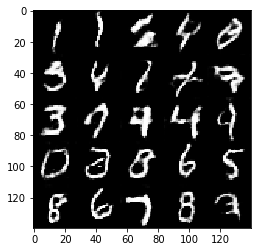

Epoch 2/2 , Batch 410/1875:  Discriminator loss = 1.4941  Generator loss = 0.4393
Epoch 2/2 , Batch 420/1875:  Discriminator loss = 1.4370  Generator loss = 0.6168
Epoch 2/2 , Batch 430/1875:  Discriminator loss = 2.1930  Generator loss = 0.2155
Epoch 2/2 , Batch 440/1875:  Discriminator loss = 0.8363  Generator loss = 1.0672
Epoch 2/2 , Batch 450/1875:  Discriminator loss = 0.8504  Generator loss = 1.0279
Epoch 2/2 , Batch 460/1875:  Discriminator loss = 2.8760  Generator loss = 0.1403
Epoch 2/2 , Batch 470/1875:  Discriminator loss = 1.7320  Generator loss = 0.3659
Epoch 2/2 , Batch 480/1875:  Discriminator loss = 1.3533  Generator loss = 0.4963
Epoch 2/2 , Batch 490/1875:  Discriminator loss = 1.4250  Generator loss = 0.4894
Epoch 2/2 , Batch 500/1875:  Discriminator loss = 0.8562  Generator loss = 1.0178


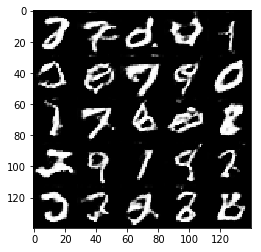

Epoch 2/2 , Batch 510/1875:  Discriminator loss = 1.3959  Generator loss = 0.5216
Epoch 2/2 , Batch 520/1875:  Discriminator loss = 0.9617  Generator loss = 0.9028
Epoch 2/2 , Batch 530/1875:  Discriminator loss = 0.8719  Generator loss = 1.9255
Epoch 2/2 , Batch 540/1875:  Discriminator loss = 0.8201  Generator loss = 2.4057
Epoch 2/2 , Batch 550/1875:  Discriminator loss = 0.8935  Generator loss = 1.0988
Epoch 2/2 , Batch 560/1875:  Discriminator loss = 0.7433  Generator loss = 1.6364
Epoch 2/2 , Batch 570/1875:  Discriminator loss = 1.4124  Generator loss = 0.5133
Epoch 2/2 , Batch 580/1875:  Discriminator loss = 0.8656  Generator loss = 1.0089
Epoch 2/2 , Batch 590/1875:  Discriminator loss = 1.4088  Generator loss = 0.6454
Epoch 2/2 , Batch 600/1875:  Discriminator loss = 1.1723  Generator loss = 0.6901


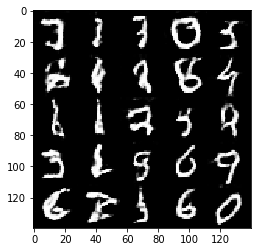

Epoch 2/2 , Batch 610/1875:  Discriminator loss = 0.7529  Generator loss = 1.3377
Epoch 2/2 , Batch 620/1875:  Discriminator loss = 1.9934  Generator loss = 3.8457
Epoch 2/2 , Batch 630/1875:  Discriminator loss = 0.7144  Generator loss = 1.3793
Epoch 2/2 , Batch 640/1875:  Discriminator loss = 1.3756  Generator loss = 0.6235
Epoch 2/2 , Batch 650/1875:  Discriminator loss = 1.8823  Generator loss = 0.2837
Epoch 2/2 , Batch 660/1875:  Discriminator loss = 1.3840  Generator loss = 0.4935
Epoch 2/2 , Batch 670/1875:  Discriminator loss = 1.1408  Generator loss = 0.6651
Epoch 2/2 , Batch 680/1875:  Discriminator loss = 0.7417  Generator loss = 1.6549
Epoch 2/2 , Batch 690/1875:  Discriminator loss = 1.0898  Generator loss = 0.7176
Epoch 2/2 , Batch 700/1875:  Discriminator loss = 1.8595  Generator loss = 0.3238


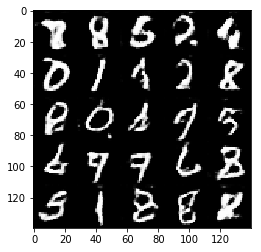

Epoch 2/2 , Batch 710/1875:  Discriminator loss = 2.1488  Generator loss = 0.2146
Epoch 2/2 , Batch 720/1875:  Discriminator loss = 0.8627  Generator loss = 1.0533
Epoch 2/2 , Batch 730/1875:  Discriminator loss = 1.6039  Generator loss = 0.4269
Epoch 2/2 , Batch 740/1875:  Discriminator loss = 1.3281  Generator loss = 2.4154
Epoch 2/2 , Batch 750/1875:  Discriminator loss = 0.7500  Generator loss = 1.3140
Epoch 2/2 , Batch 760/1875:  Discriminator loss = 0.9557  Generator loss = 1.6462
Epoch 2/2 , Batch 770/1875:  Discriminator loss = 0.7641  Generator loss = 2.0029
Epoch 2/2 , Batch 780/1875:  Discriminator loss = 1.1154  Generator loss = 0.7965
Epoch 2/2 , Batch 790/1875:  Discriminator loss = 1.3571  Generator loss = 0.5211
Epoch 2/2 , Batch 800/1875:  Discriminator loss = 0.6453  Generator loss = 1.4925


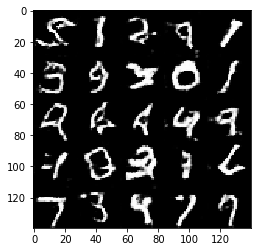

Epoch 2/2 , Batch 810/1875:  Discriminator loss = 0.8874  Generator loss = 0.9389
Epoch 2/2 , Batch 820/1875:  Discriminator loss = 0.8645  Generator loss = 1.6233
Epoch 2/2 , Batch 830/1875:  Discriminator loss = 1.1102  Generator loss = 0.7985
Epoch 2/2 , Batch 840/1875:  Discriminator loss = 2.2200  Generator loss = 0.2785
Epoch 2/2 , Batch 850/1875:  Discriminator loss = 0.9772  Generator loss = 0.9963
Epoch 2/2 , Batch 860/1875:  Discriminator loss = 1.5251  Generator loss = 0.4553
Epoch 2/2 , Batch 870/1875:  Discriminator loss = 1.0341  Generator loss = 0.7691
Epoch 2/2 , Batch 880/1875:  Discriminator loss = 1.1428  Generator loss = 0.7862
Epoch 2/2 , Batch 890/1875:  Discriminator loss = 0.7887  Generator loss = 1.9364
Epoch 2/2 , Batch 900/1875:  Discriminator loss = 1.0495  Generator loss = 1.0604


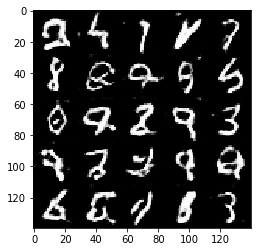

Epoch 2/2 , Batch 910/1875:  Discriminator loss = 1.0352  Generator loss = 1.7739
Epoch 2/2 , Batch 920/1875:  Discriminator loss = 0.6046  Generator loss = 1.7236
Epoch 2/2 , Batch 930/1875:  Discriminator loss = 1.0947  Generator loss = 0.7314
Epoch 2/2 , Batch 940/1875:  Discriminator loss = 0.8567  Generator loss = 2.0149
Epoch 2/2 , Batch 950/1875:  Discriminator loss = 0.9081  Generator loss = 1.6865
Epoch 2/2 , Batch 960/1875:  Discriminator loss = 1.5471  Generator loss = 0.4524
Epoch 2/2 , Batch 970/1875:  Discriminator loss = 2.0433  Generator loss = 0.3124
Epoch 2/2 , Batch 980/1875:  Discriminator loss = 1.2354  Generator loss = 4.1593
Epoch 2/2 , Batch 990/1875:  Discriminator loss = 2.8367  Generator loss = 0.1200
Epoch 2/2 , Batch 1000/1875:  Discriminator loss = 0.8821  Generator loss = 1.0918


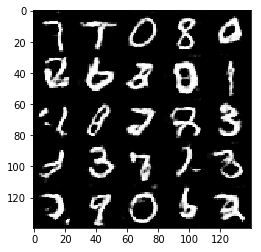

Epoch 2/2 , Batch 1010/1875:  Discriminator loss = 1.0061  Generator loss = 1.5228
Epoch 2/2 , Batch 1020/1875:  Discriminator loss = 0.7091  Generator loss = 1.4799
Epoch 2/2 , Batch 1030/1875:  Discriminator loss = 1.2014  Generator loss = 0.6758
Epoch 2/2 , Batch 1040/1875:  Discriminator loss = 2.6569  Generator loss = 0.1588
Epoch 2/2 , Batch 1050/1875:  Discriminator loss = 0.8978  Generator loss = 1.0502
Epoch 2/2 , Batch 1060/1875:  Discriminator loss = 1.6578  Generator loss = 0.3618
Epoch 2/2 , Batch 1070/1875:  Discriminator loss = 1.0546  Generator loss = 0.8053
Epoch 2/2 , Batch 1080/1875:  Discriminator loss = 0.9595  Generator loss = 0.8707
Epoch 2/2 , Batch 1090/1875:  Discriminator loss = 2.1389  Generator loss = 0.2693
Epoch 2/2 , Batch 1100/1875:  Discriminator loss = 0.7765  Generator loss = 1.2260


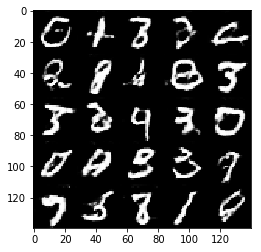

Epoch 2/2 , Batch 1110/1875:  Discriminator loss = 0.9349  Generator loss = 0.8903
Epoch 2/2 , Batch 1120/1875:  Discriminator loss = 2.4978  Generator loss = 0.1800
Epoch 2/2 , Batch 1130/1875:  Discriminator loss = 1.6316  Generator loss = 0.3881
Epoch 2/2 , Batch 1140/1875:  Discriminator loss = 1.1021  Generator loss = 1.8294
Epoch 2/2 , Batch 1150/1875:  Discriminator loss = 1.0346  Generator loss = 2.0158
Epoch 2/2 , Batch 1160/1875:  Discriminator loss = 1.0871  Generator loss = 0.7961
Epoch 2/2 , Batch 1170/1875:  Discriminator loss = 0.5999  Generator loss = 1.8225
Epoch 2/2 , Batch 1180/1875:  Discriminator loss = 0.9087  Generator loss = 2.1598
Epoch 2/2 , Batch 1190/1875:  Discriminator loss = 1.2606  Generator loss = 0.6114
Epoch 2/2 , Batch 1200/1875:  Discriminator loss = 1.7595  Generator loss = 0.3565


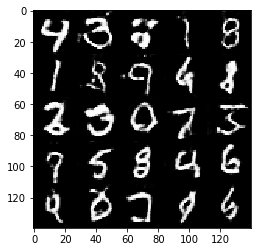

Epoch 2/2 , Batch 1210/1875:  Discriminator loss = 0.9050  Generator loss = 1.1451
Epoch 2/2 , Batch 1220/1875:  Discriminator loss = 2.6790  Generator loss = 0.1586
Epoch 2/2 , Batch 1230/1875:  Discriminator loss = 1.0129  Generator loss = 0.8692
Epoch 2/2 , Batch 1240/1875:  Discriminator loss = 0.8908  Generator loss = 1.0195
Epoch 2/2 , Batch 1250/1875:  Discriminator loss = 0.8881  Generator loss = 1.0617
Epoch 2/2 , Batch 1260/1875:  Discriminator loss = 0.5315  Generator loss = 2.1396
Epoch 2/2 , Batch 1270/1875:  Discriminator loss = 1.7045  Generator loss = 0.3944
Epoch 2/2 , Batch 1280/1875:  Discriminator loss = 2.0534  Generator loss = 4.0792
Epoch 2/2 , Batch 1290/1875:  Discriminator loss = 0.7358  Generator loss = 1.4621
Epoch 2/2 , Batch 1300/1875:  Discriminator loss = 0.9540  Generator loss = 0.9861


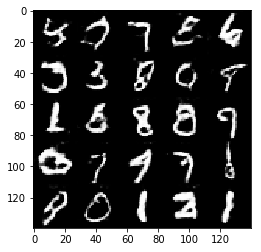

Epoch 2/2 , Batch 1310/1875:  Discriminator loss = 0.8549  Generator loss = 1.0134
Epoch 2/2 , Batch 1320/1875:  Discriminator loss = 3.4851  Generator loss = 0.1178
Epoch 2/2 , Batch 1330/1875:  Discriminator loss = 1.8763  Generator loss = 0.3402
Epoch 2/2 , Batch 1340/1875:  Discriminator loss = 1.0663  Generator loss = 0.8085
Epoch 2/2 , Batch 1350/1875:  Discriminator loss = 0.9413  Generator loss = 0.9017
Epoch 2/2 , Batch 1360/1875:  Discriminator loss = 0.8989  Generator loss = 2.0401
Epoch 2/2 , Batch 1370/1875:  Discriminator loss = 0.7486  Generator loss = 1.3566
Epoch 2/2 , Batch 1380/1875:  Discriminator loss = 0.6054  Generator loss = 1.7269
Epoch 2/2 , Batch 1390/1875:  Discriminator loss = 2.5993  Generator loss = 0.1807
Epoch 2/2 , Batch 1400/1875:  Discriminator loss = 0.6670  Generator loss = 1.3668


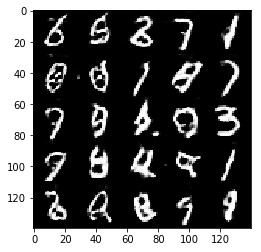

Epoch 2/2 , Batch 1410/1875:  Discriminator loss = 1.6591  Generator loss = 0.4229
Epoch 2/2 , Batch 1420/1875:  Discriminator loss = 1.5543  Generator loss = 0.5519
Epoch 2/2 , Batch 1430/1875:  Discriminator loss = 1.0544  Generator loss = 0.8554
Epoch 2/2 , Batch 1440/1875:  Discriminator loss = 0.6202  Generator loss = 1.8618
Epoch 2/2 , Batch 1450/1875:  Discriminator loss = 0.6593  Generator loss = 1.6216
Epoch 2/2 , Batch 1460/1875:  Discriminator loss = 0.6955  Generator loss = 1.3050
Epoch 2/2 , Batch 1470/1875:  Discriminator loss = 0.9357  Generator loss = 2.5171
Epoch 2/2 , Batch 1480/1875:  Discriminator loss = 0.9420  Generator loss = 0.9962
Epoch 2/2 , Batch 1490/1875:  Discriminator loss = 3.2612  Generator loss = 0.1878
Epoch 2/2 , Batch 1500/1875:  Discriminator loss = 0.6187  Generator loss = 1.7659


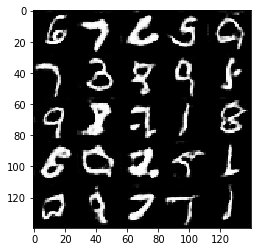

Epoch 2/2 , Batch 1510/1875:  Discriminator loss = 0.9769  Generator loss = 0.8919
Epoch 2/2 , Batch 1520/1875:  Discriminator loss = 2.1797  Generator loss = 0.2860
Epoch 2/2 , Batch 1530/1875:  Discriminator loss = 1.4655  Generator loss = 0.4873
Epoch 2/2 , Batch 1540/1875:  Discriminator loss = 1.8501  Generator loss = 0.3096
Epoch 2/2 , Batch 1550/1875:  Discriminator loss = 1.0323  Generator loss = 0.7848
Epoch 2/2 , Batch 1560/1875:  Discriminator loss = 0.8725  Generator loss = 0.9834
Epoch 2/2 , Batch 1570/1875:  Discriminator loss = 0.6751  Generator loss = 1.3439
Epoch 2/2 , Batch 1580/1875:  Discriminator loss = 1.1545  Generator loss = 3.5961
Epoch 2/2 , Batch 1590/1875:  Discriminator loss = 1.1003  Generator loss = 0.7449
Epoch 2/2 , Batch 1600/1875:  Discriminator loss = 1.2994  Generator loss = 0.6691


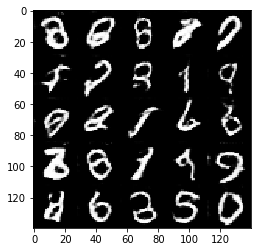

Epoch 2/2 , Batch 1610/1875:  Discriminator loss = 0.7166  Generator loss = 1.4506
Epoch 2/2 , Batch 1620/1875:  Discriminator loss = 1.3973  Generator loss = 0.5091
Epoch 2/2 , Batch 1630/1875:  Discriminator loss = 0.8709  Generator loss = 1.0068
Epoch 2/2 , Batch 1640/1875:  Discriminator loss = 0.7686  Generator loss = 1.2114
Epoch 2/2 , Batch 1650/1875:  Discriminator loss = 1.0584  Generator loss = 0.9427
Epoch 2/2 , Batch 1660/1875:  Discriminator loss = 0.7653  Generator loss = 2.6971
Epoch 2/2 , Batch 1670/1875:  Discriminator loss = 0.6946  Generator loss = 2.1827
Epoch 2/2 , Batch 1680/1875:  Discriminator loss = 3.1330  Generator loss = 0.1200
Epoch 2/2 , Batch 1690/1875:  Discriminator loss = 0.8702  Generator loss = 1.2545
Epoch 2/2 , Batch 1700/1875:  Discriminator loss = 0.5364  Generator loss = 3.5315


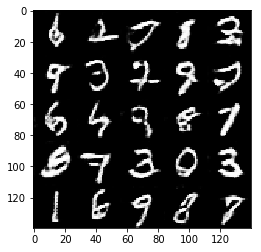

Epoch 2/2 , Batch 1710/1875:  Discriminator loss = 0.7078  Generator loss = 1.8927
Epoch 2/2 , Batch 1720/1875:  Discriminator loss = 1.8443  Generator loss = 0.3212
Epoch 2/2 , Batch 1730/1875:  Discriminator loss = 1.7999  Generator loss = 0.3303
Epoch 2/2 , Batch 1740/1875:  Discriminator loss = 1.0549  Generator loss = 1.9134
Epoch 2/2 , Batch 1750/1875:  Discriminator loss = 1.0469  Generator loss = 0.9145
Epoch 2/2 , Batch 1760/1875:  Discriminator loss = 2.1239  Generator loss = 0.2750
Epoch 2/2 , Batch 1770/1875:  Discriminator loss = 1.5779  Generator loss = 0.3955
Epoch 2/2 , Batch 1780/1875:  Discriminator loss = 0.6374  Generator loss = 2.1810
Epoch 2/2 , Batch 1790/1875:  Discriminator loss = 0.9063  Generator loss = 1.2596
Epoch 2/2 , Batch 1800/1875:  Discriminator loss = 1.1435  Generator loss = 3.1230


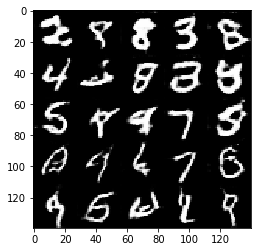

Epoch 2/2 , Batch 1810/1875:  Discriminator loss = 3.3207  Generator loss = 0.1012
Epoch 2/2 , Batch 1820/1875:  Discriminator loss = 0.9184  Generator loss = 1.0069
Epoch 2/2 , Batch 1830/1875:  Discriminator loss = 1.1690  Generator loss = 0.6823
Epoch 2/2 , Batch 1840/1875:  Discriminator loss = 1.1343  Generator loss = 2.3241
Epoch 2/2 , Batch 1850/1875:  Discriminator loss = 1.7557  Generator loss = 0.3673
Epoch 2/2 , Batch 1860/1875:  Discriminator loss = 0.8966  Generator loss = 0.9840
Epoch 2/2 , Batch 1870/1875:  Discriminator loss = 0.6218  Generator loss = 1.6729


In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 , Batch 10/3165:  Discriminator loss = 3.2419  Generator loss = 0.2056
Epoch 1/1 , Batch 20/3165:  Discriminator loss = 1.7079  Generator loss = 0.7680
Epoch 1/1 , Batch 30/3165:  Discriminator loss = 1.2746  Generator loss = 1.0463
Epoch 1/1 , Batch 40/3165:  Discriminator loss = 0.9965  Generator loss = 1.7740
Epoch 1/1 , Batch 50/3165:  Discriminator loss = 1.0335  Generator loss = 1.1640
Epoch 1/1 , Batch 60/3165:  Discriminator loss = 0.7775  Generator loss = 2.0621
Epoch 1/1 , Batch 70/3165:  Discriminator loss = 1.0371  Generator loss = 1.0416
Epoch 1/1 , Batch 80/3165:  Discriminator loss = 1.1398  Generator loss = 3.2216
Epoch 1/1 , Batch 90/3165:  Discriminator loss = 0.7707  Generator loss = 1.8309
Epoch 1/1 , Batch 100/3165:  Discriminator loss = 1.3335  Generator loss = 1.1310


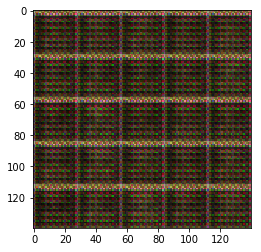

Epoch 1/1 , Batch 110/3165:  Discriminator loss = 1.1735  Generator loss = 1.8474
Epoch 1/1 , Batch 120/3165:  Discriminator loss = 1.1538  Generator loss = 1.0542
Epoch 1/1 , Batch 130/3165:  Discriminator loss = 1.1648  Generator loss = 1.2348
Epoch 1/1 , Batch 140/3165:  Discriminator loss = 1.1673  Generator loss = 0.7439
Epoch 1/1 , Batch 150/3165:  Discriminator loss = 1.6224  Generator loss = 4.0203
Epoch 1/1 , Batch 160/3165:  Discriminator loss = 0.8522  Generator loss = 1.4974
Epoch 1/1 , Batch 170/3165:  Discriminator loss = 0.8830  Generator loss = 1.3580
Epoch 1/1 , Batch 180/3165:  Discriminator loss = 1.1569  Generator loss = 0.9760
Epoch 1/1 , Batch 190/3165:  Discriminator loss = 1.5442  Generator loss = 0.6247
Epoch 1/1 , Batch 200/3165:  Discriminator loss = 1.1457  Generator loss = 1.0386


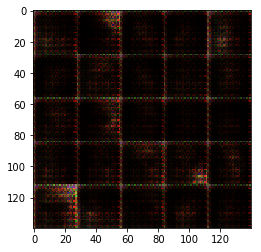

Epoch 1/1 , Batch 210/3165:  Discriminator loss = 1.0095  Generator loss = 1.5542
Epoch 1/1 , Batch 220/3165:  Discriminator loss = 1.1394  Generator loss = 0.9018
Epoch 1/1 , Batch 230/3165:  Discriminator loss = 1.3987  Generator loss = 0.8097
Epoch 1/1 , Batch 240/3165:  Discriminator loss = 1.4179  Generator loss = 0.5377
Epoch 1/1 , Batch 250/3165:  Discriminator loss = 1.2544  Generator loss = 0.8631
Epoch 1/1 , Batch 260/3165:  Discriminator loss = 1.2239  Generator loss = 0.8455
Epoch 1/1 , Batch 270/3165:  Discriminator loss = 1.0970  Generator loss = 1.0345
Epoch 1/1 , Batch 280/3165:  Discriminator loss = 1.1882  Generator loss = 0.8610
Epoch 1/1 , Batch 290/3165:  Discriminator loss = 1.1811  Generator loss = 1.3814
Epoch 1/1 , Batch 300/3165:  Discriminator loss = 1.3964  Generator loss = 0.8443


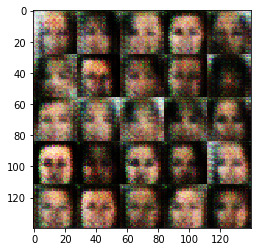

Epoch 1/1 , Batch 310/3165:  Discriminator loss = 1.1952  Generator loss = 1.2088
Epoch 1/1 , Batch 320/3165:  Discriminator loss = 1.3946  Generator loss = 1.2641
Epoch 1/1 , Batch 330/3165:  Discriminator loss = 1.2215  Generator loss = 1.3173
Epoch 1/1 , Batch 340/3165:  Discriminator loss = 1.4621  Generator loss = 0.6847
Epoch 1/1 , Batch 350/3165:  Discriminator loss = 1.3106  Generator loss = 0.8224
Epoch 1/1 , Batch 360/3165:  Discriminator loss = 1.1159  Generator loss = 1.0730
Epoch 1/1 , Batch 370/3165:  Discriminator loss = 1.1213  Generator loss = 0.7788
Epoch 1/1 , Batch 380/3165:  Discriminator loss = 1.1500  Generator loss = 1.3363
Epoch 1/1 , Batch 390/3165:  Discriminator loss = 1.1794  Generator loss = 1.0003
Epoch 1/1 , Batch 400/3165:  Discriminator loss = 1.1593  Generator loss = 0.9601


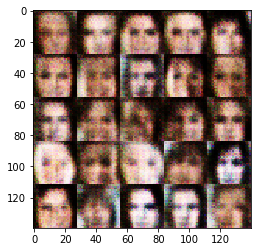

Epoch 1/1 , Batch 410/3165:  Discriminator loss = 1.1475  Generator loss = 1.7013
Epoch 1/1 , Batch 420/3165:  Discriminator loss = 1.4998  Generator loss = 0.5472
Epoch 1/1 , Batch 430/3165:  Discriminator loss = 1.1841  Generator loss = 1.0882
Epoch 1/1 , Batch 440/3165:  Discriminator loss = 1.2385  Generator loss = 0.7230
Epoch 1/1 , Batch 450/3165:  Discriminator loss = 1.1443  Generator loss = 1.2468
Epoch 1/1 , Batch 460/3165:  Discriminator loss = 1.4880  Generator loss = 0.9434
Epoch 1/1 , Batch 470/3165:  Discriminator loss = 1.6229  Generator loss = 0.7483
Epoch 1/1 , Batch 480/3165:  Discriminator loss = 1.8353  Generator loss = 0.4340
Epoch 1/1 , Batch 490/3165:  Discriminator loss = 1.4735  Generator loss = 0.6079
Epoch 1/1 , Batch 500/3165:  Discriminator loss = 1.4855  Generator loss = 0.7190


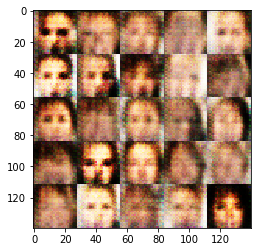

Epoch 1/1 , Batch 510/3165:  Discriminator loss = 1.7838  Generator loss = 0.9019
Epoch 1/1 , Batch 520/3165:  Discriminator loss = 1.2942  Generator loss = 0.6783
Epoch 1/1 , Batch 530/3165:  Discriminator loss = 1.7561  Generator loss = 0.4148
Epoch 1/1 , Batch 540/3165:  Discriminator loss = 0.9730  Generator loss = 1.9785
Epoch 1/1 , Batch 550/3165:  Discriminator loss = 1.3047  Generator loss = 0.8291
Epoch 1/1 , Batch 560/3165:  Discriminator loss = 1.5347  Generator loss = 0.7343
Epoch 1/1 , Batch 570/3165:  Discriminator loss = 1.3411  Generator loss = 1.0060
Epoch 1/1 , Batch 580/3165:  Discriminator loss = 1.6498  Generator loss = 0.7860
Epoch 1/1 , Batch 590/3165:  Discriminator loss = 1.2737  Generator loss = 0.8204
Epoch 1/1 , Batch 600/3165:  Discriminator loss = 1.5064  Generator loss = 0.7442


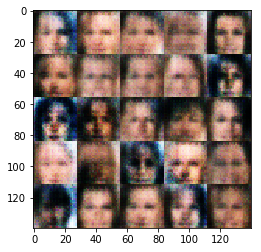

Epoch 1/1 , Batch 610/3165:  Discriminator loss = 1.2803  Generator loss = 0.8875
Epoch 1/1 , Batch 620/3165:  Discriminator loss = 1.3925  Generator loss = 0.9389
Epoch 1/1 , Batch 630/3165:  Discriminator loss = 1.3543  Generator loss = 1.0834
Epoch 1/1 , Batch 640/3165:  Discriminator loss = 1.2869  Generator loss = 0.8380
Epoch 1/1 , Batch 650/3165:  Discriminator loss = 1.3962  Generator loss = 1.2198
Epoch 1/1 , Batch 660/3165:  Discriminator loss = 1.5434  Generator loss = 0.5990
Epoch 1/1 , Batch 670/3165:  Discriminator loss = 1.4252  Generator loss = 0.6326
Epoch 1/1 , Batch 680/3165:  Discriminator loss = 1.4810  Generator loss = 0.7571
Epoch 1/1 , Batch 690/3165:  Discriminator loss = 1.5406  Generator loss = 0.9291
Epoch 1/1 , Batch 700/3165:  Discriminator loss = 1.3757  Generator loss = 1.1387


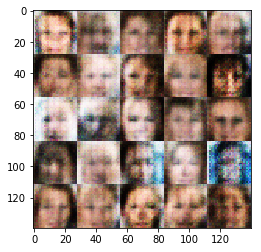

Epoch 1/1 , Batch 710/3165:  Discriminator loss = 1.3651  Generator loss = 0.7184
Epoch 1/1 , Batch 720/3165:  Discriminator loss = 1.2612  Generator loss = 1.0961
Epoch 1/1 , Batch 730/3165:  Discriminator loss = 1.5102  Generator loss = 0.6590
Epoch 1/1 , Batch 740/3165:  Discriminator loss = 1.4399  Generator loss = 0.7731
Epoch 1/1 , Batch 750/3165:  Discriminator loss = 1.4429  Generator loss = 0.7310
Epoch 1/1 , Batch 760/3165:  Discriminator loss = 1.4194  Generator loss = 0.6937
Epoch 1/1 , Batch 770/3165:  Discriminator loss = 1.5084  Generator loss = 0.9431
Epoch 1/1 , Batch 780/3165:  Discriminator loss = 1.2311  Generator loss = 0.9124
Epoch 1/1 , Batch 790/3165:  Discriminator loss = 1.3774  Generator loss = 0.6876
Epoch 1/1 , Batch 800/3165:  Discriminator loss = 1.3203  Generator loss = 0.9138


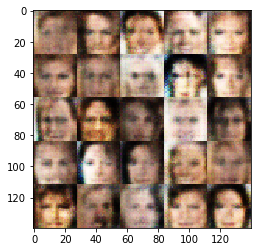

Epoch 1/1 , Batch 810/3165:  Discriminator loss = 1.4414  Generator loss = 0.9120
Epoch 1/1 , Batch 820/3165:  Discriminator loss = 1.5884  Generator loss = 0.4849
Epoch 1/1 , Batch 830/3165:  Discriminator loss = 1.5773  Generator loss = 0.5532
Epoch 1/1 , Batch 840/3165:  Discriminator loss = 1.2807  Generator loss = 0.9734
Epoch 1/1 , Batch 850/3165:  Discriminator loss = 1.3270  Generator loss = 1.0062
Epoch 1/1 , Batch 860/3165:  Discriminator loss = 1.3425  Generator loss = 0.8544
Epoch 1/1 , Batch 870/3165:  Discriminator loss = 1.4467  Generator loss = 0.6459
Epoch 1/1 , Batch 880/3165:  Discriminator loss = 1.3785  Generator loss = 0.9198
Epoch 1/1 , Batch 890/3165:  Discriminator loss = 1.3593  Generator loss = 0.8061
Epoch 1/1 , Batch 900/3165:  Discriminator loss = 1.2606  Generator loss = 0.9253


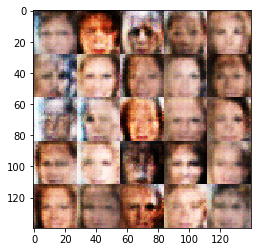

Epoch 1/1 , Batch 910/3165:  Discriminator loss = 1.4226  Generator loss = 0.6482
Epoch 1/1 , Batch 920/3165:  Discriminator loss = 1.4399  Generator loss = 0.8591
Epoch 1/1 , Batch 930/3165:  Discriminator loss = 1.3338  Generator loss = 0.7335
Epoch 1/1 , Batch 940/3165:  Discriminator loss = 1.2240  Generator loss = 0.8563
Epoch 1/1 , Batch 950/3165:  Discriminator loss = 1.3452  Generator loss = 0.9326
Epoch 1/1 , Batch 960/3165:  Discriminator loss = 1.4790  Generator loss = 0.7743
Epoch 1/1 , Batch 970/3165:  Discriminator loss = 1.5573  Generator loss = 0.7189
Epoch 1/1 , Batch 980/3165:  Discriminator loss = 1.3631  Generator loss = 0.8377
Epoch 1/1 , Batch 990/3165:  Discriminator loss = 1.2732  Generator loss = 1.1480
Epoch 1/1 , Batch 1000/3165:  Discriminator loss = 1.3253  Generator loss = 0.9563


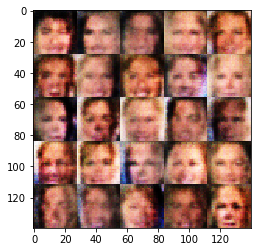

Epoch 1/1 , Batch 1010/3165:  Discriminator loss = 1.3505  Generator loss = 0.9070
Epoch 1/1 , Batch 1020/3165:  Discriminator loss = 1.3914  Generator loss = 0.7751
Epoch 1/1 , Batch 1030/3165:  Discriminator loss = 1.3966  Generator loss = 0.8479
Epoch 1/1 , Batch 1040/3165:  Discriminator loss = 1.4457  Generator loss = 0.8960
Epoch 1/1 , Batch 1050/3165:  Discriminator loss = 1.3112  Generator loss = 0.8662
Epoch 1/1 , Batch 1060/3165:  Discriminator loss = 1.3913  Generator loss = 0.7270
Epoch 1/1 , Batch 1070/3165:  Discriminator loss = 1.3678  Generator loss = 0.7816
Epoch 1/1 , Batch 1080/3165:  Discriminator loss = 1.3934  Generator loss = 0.6245
Epoch 1/1 , Batch 1090/3165:  Discriminator loss = 1.3859  Generator loss = 0.7066
Epoch 1/1 , Batch 1100/3165:  Discriminator loss = 1.3086  Generator loss = 1.1102


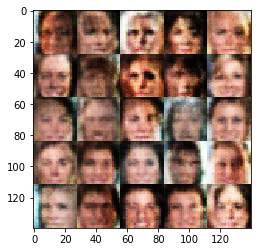

Epoch 1/1 , Batch 1110/3165:  Discriminator loss = 1.4217  Generator loss = 0.7134
Epoch 1/1 , Batch 1120/3165:  Discriminator loss = 1.2696  Generator loss = 0.8826
Epoch 1/1 , Batch 1130/3165:  Discriminator loss = 1.3733  Generator loss = 1.1468
Epoch 1/1 , Batch 1140/3165:  Discriminator loss = 1.3062  Generator loss = 1.0765
Epoch 1/1 , Batch 1150/3165:  Discriminator loss = 1.2777  Generator loss = 0.8039
Epoch 1/1 , Batch 1160/3165:  Discriminator loss = 1.4688  Generator loss = 0.6511
Epoch 1/1 , Batch 1170/3165:  Discriminator loss = 1.3350  Generator loss = 1.0558
Epoch 1/1 , Batch 1180/3165:  Discriminator loss = 1.4335  Generator loss = 0.8752
Epoch 1/1 , Batch 1190/3165:  Discriminator loss = 1.2406  Generator loss = 0.8168
Epoch 1/1 , Batch 1200/3165:  Discriminator loss = 1.4224  Generator loss = 0.6909


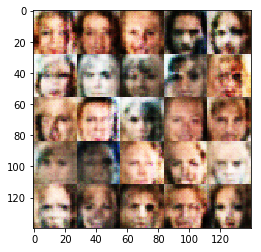

Epoch 1/1 , Batch 1210/3165:  Discriminator loss = 1.2848  Generator loss = 0.9551
Epoch 1/1 , Batch 1220/3165:  Discriminator loss = 1.3075  Generator loss = 0.8887
Epoch 1/1 , Batch 1230/3165:  Discriminator loss = 1.3971  Generator loss = 0.8302
Epoch 1/1 , Batch 1240/3165:  Discriminator loss = 1.4453  Generator loss = 0.8356
Epoch 1/1 , Batch 1250/3165:  Discriminator loss = 1.1839  Generator loss = 0.9565
Epoch 1/1 , Batch 1260/3165:  Discriminator loss = 1.2112  Generator loss = 0.8702
Epoch 1/1 , Batch 1270/3165:  Discriminator loss = 1.2851  Generator loss = 0.6706
Epoch 1/1 , Batch 1280/3165:  Discriminator loss = 1.3662  Generator loss = 0.7483
Epoch 1/1 , Batch 1290/3165:  Discriminator loss = 1.3900  Generator loss = 0.8624
Epoch 1/1 , Batch 1300/3165:  Discriminator loss = 1.4646  Generator loss = 0.8050


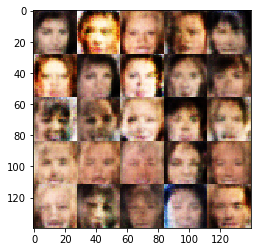

Epoch 1/1 , Batch 1310/3165:  Discriminator loss = 1.3302  Generator loss = 0.7347
Epoch 1/1 , Batch 1320/3165:  Discriminator loss = 1.3311  Generator loss = 0.7137
Epoch 1/1 , Batch 1330/3165:  Discriminator loss = 1.3930  Generator loss = 0.7491
Epoch 1/1 , Batch 1340/3165:  Discriminator loss = 1.4233  Generator loss = 0.7669
Epoch 1/1 , Batch 1350/3165:  Discriminator loss = 1.2375  Generator loss = 0.8583
Epoch 1/1 , Batch 1360/3165:  Discriminator loss = 1.1782  Generator loss = 0.9585
Epoch 1/1 , Batch 1370/3165:  Discriminator loss = 1.3893  Generator loss = 0.9559
Epoch 1/1 , Batch 1380/3165:  Discriminator loss = 1.2411  Generator loss = 1.0685
Epoch 1/1 , Batch 1390/3165:  Discriminator loss = 1.3908  Generator loss = 0.8499
Epoch 1/1 , Batch 1400/3165:  Discriminator loss = 1.3240  Generator loss = 0.9296


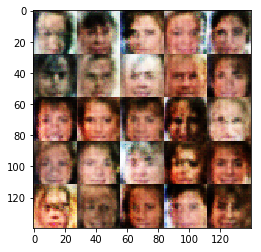

Epoch 1/1 , Batch 1410/3165:  Discriminator loss = 1.2992  Generator loss = 0.7704
Epoch 1/1 , Batch 1420/3165:  Discriminator loss = 1.3250  Generator loss = 0.8474
Epoch 1/1 , Batch 1430/3165:  Discriminator loss = 1.2251  Generator loss = 1.1633
Epoch 1/1 , Batch 1440/3165:  Discriminator loss = 1.3555  Generator loss = 0.6761
Epoch 1/1 , Batch 1450/3165:  Discriminator loss = 1.3160  Generator loss = 0.8005
Epoch 1/1 , Batch 1460/3165:  Discriminator loss = 1.3260  Generator loss = 1.1257
Epoch 1/1 , Batch 1470/3165:  Discriminator loss = 1.2987  Generator loss = 0.6876
Epoch 1/1 , Batch 1480/3165:  Discriminator loss = 1.3491  Generator loss = 0.9132
Epoch 1/1 , Batch 1490/3165:  Discriminator loss = 1.4462  Generator loss = 0.8767
Epoch 1/1 , Batch 1500/3165:  Discriminator loss = 1.2600  Generator loss = 0.9923


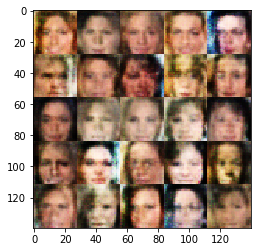

Epoch 1/1 , Batch 1510/3165:  Discriminator loss = 1.1953  Generator loss = 0.8639
Epoch 1/1 , Batch 1520/3165:  Discriminator loss = 1.4900  Generator loss = 0.6909
Epoch 1/1 , Batch 1530/3165:  Discriminator loss = 1.2692  Generator loss = 0.8980
Epoch 1/1 , Batch 1540/3165:  Discriminator loss = 1.4015  Generator loss = 0.8011
Epoch 1/1 , Batch 1550/3165:  Discriminator loss = 1.1927  Generator loss = 0.9137
Epoch 1/1 , Batch 1560/3165:  Discriminator loss = 1.2540  Generator loss = 0.9655
Epoch 1/1 , Batch 1570/3165:  Discriminator loss = 1.2840  Generator loss = 0.6825
Epoch 1/1 , Batch 1580/3165:  Discriminator loss = 1.3734  Generator loss = 0.8322
Epoch 1/1 , Batch 1590/3165:  Discriminator loss = 1.4930  Generator loss = 0.6914
Epoch 1/1 , Batch 1600/3165:  Discriminator loss = 1.4304  Generator loss = 0.9535


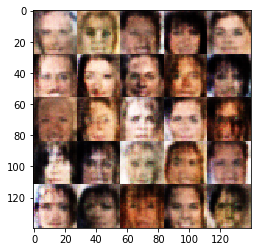

Epoch 1/1 , Batch 1610/3165:  Discriminator loss = 1.3611  Generator loss = 1.1126
Epoch 1/1 , Batch 1620/3165:  Discriminator loss = 1.2402  Generator loss = 0.7385
Epoch 1/1 , Batch 1630/3165:  Discriminator loss = 1.2893  Generator loss = 1.1668
Epoch 1/1 , Batch 1640/3165:  Discriminator loss = 1.2621  Generator loss = 0.9034
Epoch 1/1 , Batch 1650/3165:  Discriminator loss = 1.2376  Generator loss = 0.7831
Epoch 1/1 , Batch 1660/3165:  Discriminator loss = 1.5534  Generator loss = 0.6235
Epoch 1/1 , Batch 1670/3165:  Discriminator loss = 1.1885  Generator loss = 0.7921
Epoch 1/1 , Batch 1680/3165:  Discriminator loss = 1.1808  Generator loss = 0.9804
Epoch 1/1 , Batch 1690/3165:  Discriminator loss = 1.5350  Generator loss = 0.5975
Epoch 1/1 , Batch 1700/3165:  Discriminator loss = 1.3224  Generator loss = 0.7708


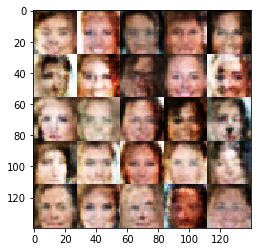

Epoch 1/1 , Batch 1710/3165:  Discriminator loss = 1.2981  Generator loss = 0.8825
Epoch 1/1 , Batch 1720/3165:  Discriminator loss = 1.2795  Generator loss = 0.7390
Epoch 1/1 , Batch 1730/3165:  Discriminator loss = 1.4173  Generator loss = 0.7509
Epoch 1/1 , Batch 1740/3165:  Discriminator loss = 1.2440  Generator loss = 1.1757
Epoch 1/1 , Batch 1750/3165:  Discriminator loss = 1.3104  Generator loss = 0.9079
Epoch 1/1 , Batch 1760/3165:  Discriminator loss = 1.3252  Generator loss = 1.1102
Epoch 1/1 , Batch 1770/3165:  Discriminator loss = 1.2554  Generator loss = 1.0130
Epoch 1/1 , Batch 1780/3165:  Discriminator loss = 1.3008  Generator loss = 0.7801
Epoch 1/1 , Batch 1790/3165:  Discriminator loss = 1.3496  Generator loss = 0.8934
Epoch 1/1 , Batch 1800/3165:  Discriminator loss = 1.5132  Generator loss = 0.5264


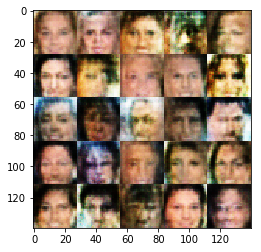

Epoch 1/1 , Batch 1810/3165:  Discriminator loss = 1.6170  Generator loss = 0.7185
Epoch 1/1 , Batch 1820/3165:  Discriminator loss = 1.4281  Generator loss = 0.6356
Epoch 1/1 , Batch 1830/3165:  Discriminator loss = 1.3170  Generator loss = 0.9402
Epoch 1/1 , Batch 1840/3165:  Discriminator loss = 1.3172  Generator loss = 0.8917
Epoch 1/1 , Batch 1850/3165:  Discriminator loss = 1.5825  Generator loss = 0.5932
Epoch 1/1 , Batch 1860/3165:  Discriminator loss = 1.4564  Generator loss = 0.7866
Epoch 1/1 , Batch 1870/3165:  Discriminator loss = 1.4324  Generator loss = 0.7411
Epoch 1/1 , Batch 1880/3165:  Discriminator loss = 1.4733  Generator loss = 0.7874
Epoch 1/1 , Batch 1890/3165:  Discriminator loss = 1.4201  Generator loss = 0.7749
Epoch 1/1 , Batch 1900/3165:  Discriminator loss = 1.3166  Generator loss = 0.7851


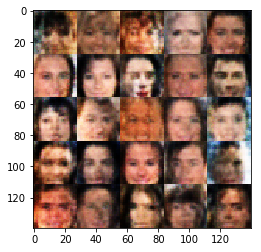

Epoch 1/1 , Batch 1910/3165:  Discriminator loss = 1.4077  Generator loss = 0.6734
Epoch 1/1 , Batch 1920/3165:  Discriminator loss = 1.5982  Generator loss = 0.6087
Epoch 1/1 , Batch 1930/3165:  Discriminator loss = 1.5530  Generator loss = 0.6293
Epoch 1/1 , Batch 1940/3165:  Discriminator loss = 1.3888  Generator loss = 0.6906
Epoch 1/1 , Batch 1950/3165:  Discriminator loss = 1.3484  Generator loss = 0.6781
Epoch 1/1 , Batch 1960/3165:  Discriminator loss = 1.3558  Generator loss = 0.8468
Epoch 1/1 , Batch 1970/3165:  Discriminator loss = 1.1760  Generator loss = 1.0229
Epoch 1/1 , Batch 1980/3165:  Discriminator loss = 1.3165  Generator loss = 0.9271
Epoch 1/1 , Batch 1990/3165:  Discriminator loss = 1.3786  Generator loss = 1.1070
Epoch 1/1 , Batch 2000/3165:  Discriminator loss = 1.4300  Generator loss = 0.5504


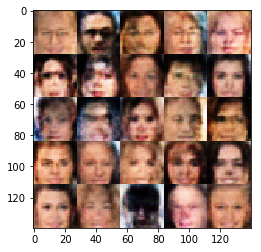

Epoch 1/1 , Batch 2010/3165:  Discriminator loss = 1.3270  Generator loss = 0.9290
Epoch 1/1 , Batch 2020/3165:  Discriminator loss = 1.4366  Generator loss = 0.8243
Epoch 1/1 , Batch 2030/3165:  Discriminator loss = 1.4319  Generator loss = 1.0666
Epoch 1/1 , Batch 2040/3165:  Discriminator loss = 1.2704  Generator loss = 0.8486
Epoch 1/1 , Batch 2050/3165:  Discriminator loss = 1.4971  Generator loss = 0.7703
Epoch 1/1 , Batch 2060/3165:  Discriminator loss = 1.3650  Generator loss = 0.8117
Epoch 1/1 , Batch 2070/3165:  Discriminator loss = 1.6618  Generator loss = 0.4871
Epoch 1/1 , Batch 2080/3165:  Discriminator loss = 1.2448  Generator loss = 0.9391
Epoch 1/1 , Batch 2090/3165:  Discriminator loss = 1.3424  Generator loss = 0.8958
Epoch 1/1 , Batch 2100/3165:  Discriminator loss = 1.3221  Generator loss = 0.9957


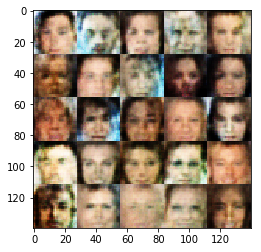

Epoch 1/1 , Batch 2110/3165:  Discriminator loss = 1.4521  Generator loss = 0.8155
Epoch 1/1 , Batch 2120/3165:  Discriminator loss = 1.1991  Generator loss = 1.2206
Epoch 1/1 , Batch 2130/3165:  Discriminator loss = 1.3635  Generator loss = 0.7948
Epoch 1/1 , Batch 2140/3165:  Discriminator loss = 1.2460  Generator loss = 0.9304
Epoch 1/1 , Batch 2150/3165:  Discriminator loss = 1.5661  Generator loss = 0.5479
Epoch 1/1 , Batch 2160/3165:  Discriminator loss = 1.4152  Generator loss = 0.6229
Epoch 1/1 , Batch 2170/3165:  Discriminator loss = 1.6226  Generator loss = 0.4759
Epoch 1/1 , Batch 2180/3165:  Discriminator loss = 1.2253  Generator loss = 0.8887
Epoch 1/1 , Batch 2190/3165:  Discriminator loss = 1.2157  Generator loss = 0.9690
Epoch 1/1 , Batch 2200/3165:  Discriminator loss = 1.3708  Generator loss = 0.8805


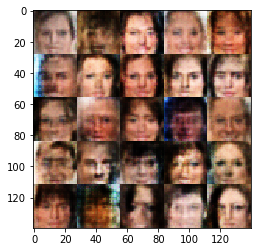

Epoch 1/1 , Batch 2210/3165:  Discriminator loss = 1.3974  Generator loss = 0.8580
Epoch 1/1 , Batch 2220/3165:  Discriminator loss = 1.2904  Generator loss = 0.9486
Epoch 1/1 , Batch 2230/3165:  Discriminator loss = 1.2764  Generator loss = 1.1191
Epoch 1/1 , Batch 2240/3165:  Discriminator loss = 1.2668  Generator loss = 0.7914
Epoch 1/1 , Batch 2250/3165:  Discriminator loss = 1.3942  Generator loss = 0.7471
Epoch 1/1 , Batch 2260/3165:  Discriminator loss = 1.2568  Generator loss = 0.9696
Epoch 1/1 , Batch 2270/3165:  Discriminator loss = 1.4623  Generator loss = 0.6261
Epoch 1/1 , Batch 2280/3165:  Discriminator loss = 1.3606  Generator loss = 0.9802
Epoch 1/1 , Batch 2290/3165:  Discriminator loss = 1.5723  Generator loss = 0.6152
Epoch 1/1 , Batch 2300/3165:  Discriminator loss = 1.6201  Generator loss = 0.4853


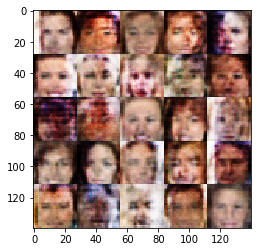

Epoch 1/1 , Batch 2310/3165:  Discriminator loss = 1.3030  Generator loss = 0.8907
Epoch 1/1 , Batch 2320/3165:  Discriminator loss = 1.4904  Generator loss = 0.6605
Epoch 1/1 , Batch 2330/3165:  Discriminator loss = 1.3133  Generator loss = 0.8284
Epoch 1/1 , Batch 2340/3165:  Discriminator loss = 1.5540  Generator loss = 0.5773
Epoch 1/1 , Batch 2350/3165:  Discriminator loss = 1.4032  Generator loss = 0.6708
Epoch 1/1 , Batch 2360/3165:  Discriminator loss = 1.4817  Generator loss = 0.8158
Epoch 1/1 , Batch 2370/3165:  Discriminator loss = 1.5673  Generator loss = 0.5857
Epoch 1/1 , Batch 2380/3165:  Discriminator loss = 1.5555  Generator loss = 0.6299
Epoch 1/1 , Batch 2390/3165:  Discriminator loss = 1.3211  Generator loss = 0.8245
Epoch 1/1 , Batch 2400/3165:  Discriminator loss = 1.3108  Generator loss = 0.7537


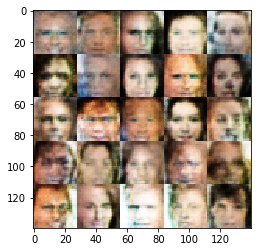

Epoch 1/1 , Batch 2410/3165:  Discriminator loss = 1.4330  Generator loss = 0.6351
Epoch 1/1 , Batch 2420/3165:  Discriminator loss = 1.2917  Generator loss = 0.9050
Epoch 1/1 , Batch 2430/3165:  Discriminator loss = 1.3705  Generator loss = 0.6380
Epoch 1/1 , Batch 2440/3165:  Discriminator loss = 1.4423  Generator loss = 0.6455
Epoch 1/1 , Batch 2450/3165:  Discriminator loss = 1.3234  Generator loss = 0.9730
Epoch 1/1 , Batch 2460/3165:  Discriminator loss = 1.3522  Generator loss = 0.9781
Epoch 1/1 , Batch 2470/3165:  Discriminator loss = 1.2970  Generator loss = 0.9502
Epoch 1/1 , Batch 2480/3165:  Discriminator loss = 1.2972  Generator loss = 0.8442
Epoch 1/1 , Batch 2490/3165:  Discriminator loss = 1.4003  Generator loss = 0.9520
Epoch 1/1 , Batch 2500/3165:  Discriminator loss = 1.4342  Generator loss = 0.7231


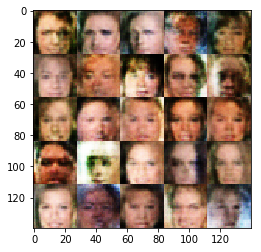

Epoch 1/1 , Batch 2510/3165:  Discriminator loss = 1.2047  Generator loss = 1.0283
Epoch 1/1 , Batch 2520/3165:  Discriminator loss = 1.4136  Generator loss = 0.9721
Epoch 1/1 , Batch 2530/3165:  Discriminator loss = 1.3446  Generator loss = 0.9481
Epoch 1/1 , Batch 2540/3165:  Discriminator loss = 1.1982  Generator loss = 0.8921
Epoch 1/1 , Batch 2550/3165:  Discriminator loss = 1.2985  Generator loss = 0.8281
Epoch 1/1 , Batch 2560/3165:  Discriminator loss = 1.2990  Generator loss = 0.7349
Epoch 1/1 , Batch 2570/3165:  Discriminator loss = 1.2551  Generator loss = 1.0365
Epoch 1/1 , Batch 2580/3165:  Discriminator loss = 1.3060  Generator loss = 0.8360
Epoch 1/1 , Batch 2590/3165:  Discriminator loss = 1.5592  Generator loss = 0.5107
Epoch 1/1 , Batch 2600/3165:  Discriminator loss = 1.2779  Generator loss = 0.9528


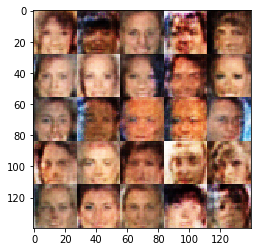

Epoch 1/1 , Batch 2610/3165:  Discriminator loss = 1.2740  Generator loss = 0.9760
Epoch 1/1 , Batch 2620/3165:  Discriminator loss = 1.3327  Generator loss = 0.6999
Epoch 1/1 , Batch 2630/3165:  Discriminator loss = 1.4639  Generator loss = 0.6978
Epoch 1/1 , Batch 2640/3165:  Discriminator loss = 1.4012  Generator loss = 0.7158
Epoch 1/1 , Batch 2650/3165:  Discriminator loss = 1.3687  Generator loss = 0.8120
Epoch 1/1 , Batch 2660/3165:  Discriminator loss = 1.5476  Generator loss = 0.6895
Epoch 1/1 , Batch 2670/3165:  Discriminator loss = 1.3654  Generator loss = 0.7995
Epoch 1/1 , Batch 2680/3165:  Discriminator loss = 1.4662  Generator loss = 0.7050
Epoch 1/1 , Batch 2690/3165:  Discriminator loss = 1.3268  Generator loss = 0.7742
Epoch 1/1 , Batch 2700/3165:  Discriminator loss = 1.1756  Generator loss = 1.0106


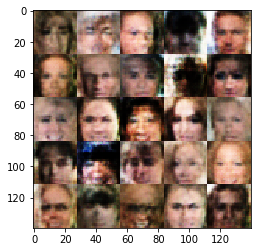

Epoch 1/1 , Batch 2710/3165:  Discriminator loss = 1.4111  Generator loss = 0.6581
Epoch 1/1 , Batch 2720/3165:  Discriminator loss = 1.2853  Generator loss = 0.7726
Epoch 1/1 , Batch 2730/3165:  Discriminator loss = 1.4138  Generator loss = 0.8560
Epoch 1/1 , Batch 2740/3165:  Discriminator loss = 1.4051  Generator loss = 0.6469
Epoch 1/1 , Batch 2750/3165:  Discriminator loss = 1.3263  Generator loss = 0.6789
Epoch 1/1 , Batch 2760/3165:  Discriminator loss = 1.4295  Generator loss = 0.7071
Epoch 1/1 , Batch 2770/3165:  Discriminator loss = 1.2314  Generator loss = 0.8008
Epoch 1/1 , Batch 2780/3165:  Discriminator loss = 1.3441  Generator loss = 0.8967
Epoch 1/1 , Batch 2790/3165:  Discriminator loss = 1.4612  Generator loss = 0.6605
Epoch 1/1 , Batch 2800/3165:  Discriminator loss = 1.3656  Generator loss = 0.7609


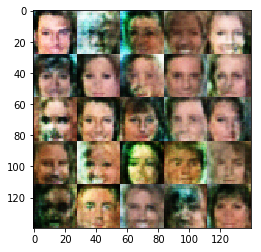

Epoch 1/1 , Batch 2810/3165:  Discriminator loss = 1.3422  Generator loss = 0.7817
Epoch 1/1 , Batch 2820/3165:  Discriminator loss = 1.2272  Generator loss = 0.7582
Epoch 1/1 , Batch 2830/3165:  Discriminator loss = 1.2230  Generator loss = 1.0863
Epoch 1/1 , Batch 2840/3165:  Discriminator loss = 1.7265  Generator loss = 0.5146
Epoch 1/1 , Batch 2850/3165:  Discriminator loss = 1.4113  Generator loss = 0.9009
Epoch 1/1 , Batch 2860/3165:  Discriminator loss = 1.4869  Generator loss = 0.9393
Epoch 1/1 , Batch 2870/3165:  Discriminator loss = 1.3546  Generator loss = 0.7365
Epoch 1/1 , Batch 2880/3165:  Discriminator loss = 1.3171  Generator loss = 0.7942
Epoch 1/1 , Batch 2890/3165:  Discriminator loss = 1.4356  Generator loss = 0.7020
Epoch 1/1 , Batch 2900/3165:  Discriminator loss = 1.3726  Generator loss = 0.9207


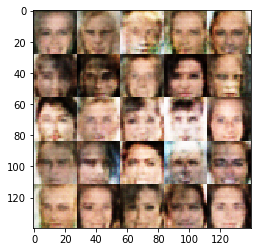

Epoch 1/1 , Batch 2910/3165:  Discriminator loss = 1.3879  Generator loss = 0.7556
Epoch 1/1 , Batch 2920/3165:  Discriminator loss = 1.3580  Generator loss = 0.7875
Epoch 1/1 , Batch 2930/3165:  Discriminator loss = 1.3504  Generator loss = 0.6933
Epoch 1/1 , Batch 2940/3165:  Discriminator loss = 1.4149  Generator loss = 0.7808
Epoch 1/1 , Batch 2950/3165:  Discriminator loss = 1.3424  Generator loss = 0.8729
Epoch 1/1 , Batch 2960/3165:  Discriminator loss = 1.4666  Generator loss = 0.8386
Epoch 1/1 , Batch 2970/3165:  Discriminator loss = 1.2316  Generator loss = 0.9440
Epoch 1/1 , Batch 2980/3165:  Discriminator loss = 1.3935  Generator loss = 0.9728
Epoch 1/1 , Batch 2990/3165:  Discriminator loss = 1.2988  Generator loss = 0.7610
Epoch 1/1 , Batch 3000/3165:  Discriminator loss = 1.3980  Generator loss = 0.6888


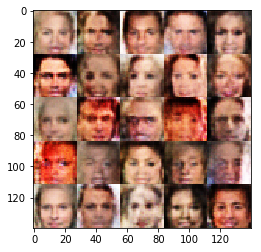

Epoch 1/1 , Batch 3010/3165:  Discriminator loss = 1.4058  Generator loss = 0.6861
Epoch 1/1 , Batch 3020/3165:  Discriminator loss = 1.1906  Generator loss = 0.8400
Epoch 1/1 , Batch 3030/3165:  Discriminator loss = 1.3638  Generator loss = 0.7815
Epoch 1/1 , Batch 3040/3165:  Discriminator loss = 1.6241  Generator loss = 0.7132
Epoch 1/1 , Batch 3050/3165:  Discriminator loss = 1.4093  Generator loss = 0.9525
Epoch 1/1 , Batch 3060/3165:  Discriminator loss = 1.4129  Generator loss = 0.8396
Epoch 1/1 , Batch 3070/3165:  Discriminator loss = 1.3112  Generator loss = 0.8134
Epoch 1/1 , Batch 3080/3165:  Discriminator loss = 1.2914  Generator loss = 0.8759
Epoch 1/1 , Batch 3090/3165:  Discriminator loss = 1.3625  Generator loss = 0.7868
Epoch 1/1 , Batch 3100/3165:  Discriminator loss = 1.2259  Generator loss = 0.8970


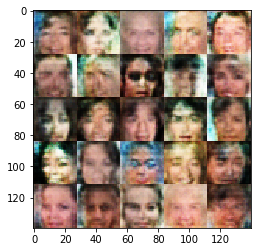

Epoch 1/1 , Batch 3110/3165:  Discriminator loss = 1.5401  Generator loss = 0.6707
Epoch 1/1 , Batch 3120/3165:  Discriminator loss = 1.4484  Generator loss = 0.8238
Epoch 1/1 , Batch 3130/3165:  Discriminator loss = 1.3850  Generator loss = 0.7538
Epoch 1/1 , Batch 3140/3165:  Discriminator loss = 1.2925  Generator loss = 0.7283
Epoch 1/1 , Batch 3150/3165:  Discriminator loss = 1.2986  Generator loss = 0.7773
Epoch 1/1 , Batch 3160/3165:  Discriminator loss = 1.4523  Generator loss = 0.6491


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.